## Matrix Multiplication from Foundations
The foundations we assume from this course are:
* Python
* Python modules (non-DL)
* Pytorch indexable tensor, and tensor creation (including random number generators (RNGs))
* fastai.datasets

## Check imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from exp.nb_00 import *
import operator

In [3]:
def test(a, b, cmp, cname=None):
    if cname is None: 
        cname = cmp.__name__
    assert cmp(a, b), f"{cname}:\n{a}\n{b}"

In [4]:
def test_eq(a, b):
    test(a, b, operator.eq)

In [6]:
test_eq(TEST, 'test')

In [7]:
! python run_notebook.py 01_matmul.ipynb

Traceback (most recent call last):
  File "run_notebook.py", line 4, in <module>
    from nbconvert.preprocessors import ExecutePreprocessor
  File "/opt/anaconda3/lib/python3.7/site-packages/nbconvert/__init__.py", line 7, in <module>
    from . import postprocessors
  File "/opt/anaconda3/lib/python3.7/site-packages/nbconvert/postprocessors/__init__.py", line 5, in <module>
    from .serve import ServePostProcessor
  File "/opt/anaconda3/lib/python3.7/site-packages/nbconvert/postprocessors/serve.py", line 19, in <module>
    class ProxyHandler(web.RequestHandler):
  File "/opt/anaconda3/lib/python3.7/site-packages/nbconvert/postprocessors/serve.py", line 21, in ProxyHandler
    @web.asynchronous
AttributeError: module 'tornado.web' has no attribute 'asynchronous'


## Get data

In [8]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl, matplotlib.pyplot as plt
from torch import tensor

In [9]:
MNIST_URL = 'http://deeplearning.net/data/mnist/mnist.pkl'

In [10]:
path = datasets.download_data(MNIST_URL, ext='.gz'); path

PosixPath('/home/jupyter/.fastai/data/mnist.pkl.gz')

In [11]:
! file {path}

/home/jupyter/.fastai/data/mnist.pkl.gz: gzip compressed data, was "mnist.pkl", last modified: Thu Jan 14 17:32:04 2010, max compression


In [12]:
gzip.open(path)

<gzip _io.BufferedReader name='/home/jupyter/.fastai/data/mnist.pkl.gz' 0x7f9b7591d198>

In [13]:
with gzip.open(path, mode='rb') as f:
    (x_train, y_train), (x_valid, y_valid), _ = pickle.load(f, encoding='latin-1')

In [14]:
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

In [15]:
n, c = x_train.shape

In [16]:
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [17]:
assert n == y_train.shape[0] == 50000

In [18]:
test_eq(c, 28 * 28)
test_eq(y_train.min(), 0)
test_eq(y_train.max(), 9)

In [19]:
mpl.rcParams['image.cmap'] = 'gray'

In [23]:
img = x_train[17]

In [21]:
img.view(28, 28).type()

'torch.FloatTensor'

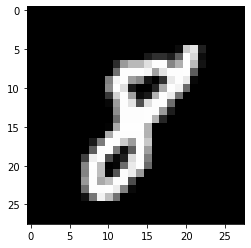

In [24]:
plt.imshow(img.view(28, 28));

## Initial Python model

In [25]:
img.shape

torch.Size([784])

In [26]:
weights = torch.randn(784, 10)

In [27]:
bias = torch.zeros(10)

#### Matrix multiplication

In [28]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i,j] += a[i,k] * b[k,j]
    return c

In [29]:
m1 = x_valid[:5]
m2 = weights

In [30]:
%%time 
t1 = matmul(m1, m2)

CPU times: user 608 ms, sys: 0 ns, total: 608 ms
Wall time: 691 ms


In [31]:
t1.shape

torch.Size([5, 10])

In [32]:
len(x_train)

50000

#### Elementwise ops
Operators, (+, -, *, /, >, <, ==), are usually elementwise.

Examples of elementwise operations:

In [33]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])

In [34]:
a, b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [35]:
a + b

tensor([12., 14.,  3.])

In [36]:
(a < b).float().mean()

tensor(0.6667)

In [37]:
m = tensor([[1, 2, 3], [4., 5, 6], [7, 8, 9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [38]:
(m * m).sum().sqrt()

tensor(16.8819)

#### Elementwise matmul()

In [41]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i,j] = (a[i,:]*b[:,j]).sum()
    return c

In [52]:
%%timeit -n 10 

_ = matmul(m1, m2)

1.02 ms ± 32.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [54]:
def near(a, b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a, b): test(a, b, near)    

In [56]:
test_near(t1, matmul(m1, m2))

### Broadcasting

#### Broadcasting with a scalar

In [57]:
a

tensor([10.,  6., -4.])

In [58]:
a > 0

tensor([1, 1, 0], dtype=torch.uint8)

In [59]:
a + 1

tensor([11.,  7., -3.])

In [60]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [61]:
2 * m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

#### Broadcasting a vector to a matrix

In [62]:
c = tensor([10., 20, 30]); c

tensor([10., 20., 30.])

In [64]:
m.shape, c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [65]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [66]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [70]:
t = c.expand_as(m)

In [71]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [76]:
t.storage(), c.storage()

( 10.0
  20.0
  30.0
 [torch.FloatStorage of size 3],  10.0
  20.0
  30.0
 [torch.FloatStorage of size 3])

In [78]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

In [84]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [83]:
m.storage()

 1.0
 2.0
 3.0
 4.0
 5.0
 6.0
 7.0
 8.0
 9.0
[torch.FloatStorage of size 9]

In [80]:
m.stride()

(3, 1)

In [85]:
c.stride()

(1,)

In [86]:
c.shape, c.unsqueeze(0).shape, c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [87]:
c.shape, c[None,:].shape, c[:,None].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [89]:
c.shape, c[None,...].shape, c[...,None].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [90]:
c.shape, c[None].shape, c[...,None].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [93]:
c[None].shape, c[None].expand_as(m)

(torch.Size([1, 3]), tensor([[10., 20., 30.],
         [10., 20., 30.],
         [10., 20., 30.]]))

In [94]:
c[...,None].shape, c[...,None].expand_as(m)

(torch.Size([3, 1]), tensor([[10., 10., 10.],
         [20., 20., 20.],
         [30., 30., 30.]]))

In [96]:
m + c[...,None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

#### Matmul with broadcasting

In [117]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        c[i] = (a[i][...,None] * b).sum(dim=0)
    return c

In [121]:
%%timeit -n 7 

_ = matmul(m1, m2)

211 µs ± 17.6 µs per loop (mean ± std. dev. of 7 runs, 7 loops each)


In [120]:
test_near(t1, matmul(m1, m2))

#### Broadcasting rules

In [122]:
c

tensor([10., 20., 30.])

In [128]:
c[None,:]

tensor([[10., 20., 30.]])

In [129]:
c[:,None]

tensor([[10.],
        [20.],
        [30.]])

In [126]:
c[:,None] * c[None,:]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

In [127]:
c[None,:] * c[:,None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

In [130]:
c[None,:] > c[:,None]

tensor([[0, 1, 1],
        [0, 0, 1],
        [0, 0, 0]], dtype=torch.uint8)

### Einstein summation

In [133]:
def matmul(a, b): return torch.einsum('ik,kj->ij', a, b)

In [134]:
%%timeit -n 10

_ = matmul(m1, m2)

45.2 µs ± 7.12 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [135]:
test_near(t1, matmul(m1, m2))

### Pytorch op

In [137]:
%%timeit -n 10

_ = m1.matmul(m2)

9.94 µs ± 5.71 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [138]:
test_near(t1, m1.matmul(m2))

In [139]:
%%timeit -n 10

_ = m1 @ m2

8.89 µs ± 4.81 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [140]:
test_near(t1, m1 @ m2)

In [141]:
m3, m4 = m1.cuda(), m2.cuda()

In [147]:
%%timeit -n 10

_ = m3 @ m4

11.7 µs ± 5.33 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# fin